#Problem statement and experimental setup

Let us restate the hypothesis that we are trying to verify. 

Let $M$ be a GNN with the aggregation scheme
$$
y_v^1 = \sum_{u \in N(v)}\alpha_{vu}W_1x_u 
$$

where $\alpha_{vu} \sim D(n)$ are independent and $N(v)$ follows a distribution according to the random graph model. Then if the distribution $D(n)$ and the random graph model are such that $D(n) \times |N(v)| \to c$ almost surely, then $y_v^1$ tends to $c \mu$ almost surely as $n$ tends to infinity and the GNN satisfies a zero one law.
Note that there are in fact two claims: one is that $y_v^1$ tends to $c \mu$ almost surely as $n$ tends to infinity and the other is that the GNN satisfies a zero one law. Neither claim directly implies the other so we must verify both.  

To do this, we will have two different setups. For the first claim, we will only have a 1 layer GNN and we will only be interested in the preactivations of one arbitrary node, meaning we will not pass it through a nonlinearity nor a classifier. We will be interested in verifying two things: 
1. Can we see convergence to $c \mu$? 
2. Is the convergence almost sure?

One might argue that the second condition is not that interesting, because convergence in probability is good enough. This is probably true, but recall that in the report, we were also exploring the connection of the zero one laws to the strong law of large numbers. In this sense, almost sure convergence is absolutely essential - if it is a different type of convergence, it is not the strong law that is driving the mechanism. I believe it deserves to be verified. 


For the second claim, we will have a multilayer GNN and we will look at the graph labels. 

In both cases we will only consider the Erdos-Renyi random graph model but the claim is more general. The report is already quite long, so I defer this task to someone else. 

#Claim 1: Almost sure convergence

##Experiments 

In [ ]:
!pip install torch==1.12.1+cu113 torchvision==0.13.1+cu113 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu113
!pip install networkx

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu113
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 691.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.4/23.4 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 1.13.1+cu116
    Uninstalling torch-1.13.1+cu116:
      Successfully uninstalled torch-1.13.1+cu116
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.1+cu116
    Uninstalling torchvision-0.14.1+cu116:
      Successfully uninstalled torchvision-0.14.1+cu116
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.13.1+cu116
    Uninstalling torchaudio-0.13.1+cu116:
      Successfully uninstalled torchaudio-0.13.1+cu116
ERROR: pip's dependency resolver does not currently take into account 

Before we do anything, I need to explain the difference between almost sure convergence and convergence in probability. You can find the definitions in the appendix. Recall that one can prove whether something converges almost surely/in probability, by using the Borel Cantelli lemmas.

The real question is, how can we observe this difference in experiments? 

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_geometric

Example of something that converges in probability but not almost surely is the sequence $X_n \sim Ber(1/n)$:

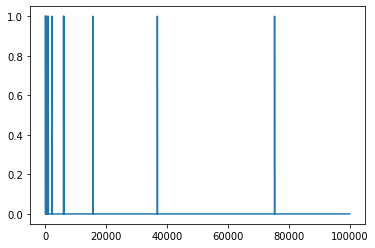

In [ ]:
#this random variable converges to 0 in probability but not almost surely. You always have an infinite subsequence of 1's
output = []
for i in range(1,100000):
  x = np.random.binomial(1,1/i)
  output.append(x)

plt.plot(output)

If we slightly change this to $X_n \sim Ber(1/n^2)$ we get almost sure convergence:

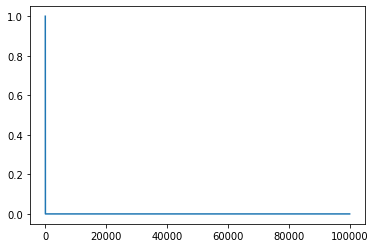

In [ ]:
#this random variable converges to 0 both in probability and also almost surely. You never have an infinite subsequence of 1's
output = []
for i in range(1,100000):
  x = np.random.binomial(1,1/i**2)
  output.append(x)

plt.plot(output)

As the definitions suggest, the difference is in infinite occurences of "bad" values. If something converges in probability, but not almost surely, you are guaranteed (with probability 1) to find an infinite sequence of "bad" values as is shown above. If you have almost sure convergence, you are guaranteed that this will not happen. 

In continuous random variables, the plots are not as nice as the ones above. Luckily, in most of our experiments, the difference will be easy to spot. Obviously, this will be done in a non-rigorous way, but that is the only way to verify this experimentally. Recall that our conjecture is motivated by theory - these experiments should act as guidance whether we are thinking in the right direction.

Now let's setup a 1 layer network, sample graphs from the Erdos-Renyi model of size 2 to 500  and experiment with different distributions on the attention weights.

In [ ]:
def generate_erdos_renyi(num_nodes,edge_probability):
  #generates erdos renyi graphs
  
  return torch_geometric.utils.random.erdos_renyi_graph(num_nodes, edge_probability, directed = False)

def generate_node_features(num_nodes, dimension = 2, mu = 1, std = 1):
  # generates node features - we will start with the normal distribution but later try not subgaussian

  return torch.normal(mean=mu*torch.ones(num_nodes,dimension), std= torch.tensor([std]))

def experiment(X_dim, net, num_graphs = 500, r = 1):
  output = []
  #samples random graphs of size 1,2 .. num_graphs (one graph for each size) with random features

  for n in range(2,num_graphs):
    #prepare self loops
    self_loops = torch.arange(n).reshape(1,n)
    edge_index0 = torch.cat((self_loops,self_loops), dim = 0 )

    #generate random graph from G(n,r)
    edge_index = torch.cat((generate_erdos_renyi(n,r),edge_index0), dim = 1) 
    adj = torch_geometric.utils.to_dense_adj(edge_index)[0] 

    #generate node features
    X = generate_node_features(n,X_dim)

    Y_n = net.forward(adj,X,r)
  
    output.append(Y_n[0]) #only look at one vertex 
  
  return output

We begin with something which we know converges almost surely, to understand what the plots should look like. This is exactly the case of a GCN on a **fully connected** graph (meaning r = 1 in the ER model). The reason why we know this converges almost surely is that now, every node has a neighborhood exactly equal to $n$ and thus the aggregation is exactly:

$$
y_v^1 = \frac{X_1 + \dots X_n}{n}
$$
which is exactly the strong law of large numbers.

(here $X_i = Wx_i$)

In [ ]:
#Now implement a single 1 layer GCN - we will later tweak this to get different distribtuions

class GCN():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)

  def forward(self,adj,X,r):
   
    D = torch.diag(torch.sum(adj,dim = 0))
 
    D_sqrt = torch.linalg.inv(torch.sqrt(D))
    conv = D_sqrt @ adj @ D_sqrt
  
    prod =  conv @ X @ self.W

    return prod

In [ ]:
#start with 2 dimensional features and 3 dimensional output. This doesnt really matter
X_dim = 2
out_channels = 3

mu = 1*torch.ones(1,X_dim) #mean vector of the feature distribution 

#the expected value (the value we should converge to) is just c*(W*mu)

net = GCN(X_dim, out_channels)
target = mu@net.W
target

tensor([[1.3806, 1.2795, 0.7290]])

In [ ]:
output = experiment(X_dim, net, 500)
diff1 = []

for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output. Look at only 1 component  


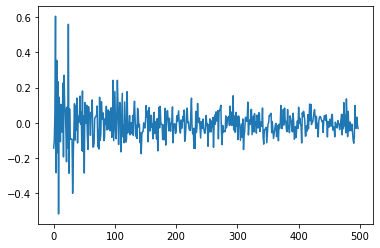

In [ ]:
# we see nice convergence to 0. We know from theory, that this is almost sure convergence. 
plt.plot(diff1)

We see that the output converges to the mean. Note that this is just the GCN with $r = 1$ (which we know converges almost surely). Let's now consider the general model and experiment with different distributions. 

Using the Borel Cantelli lemma, one can prove that if $D(n) \sim Bin(n,r)$, then $D(n) \times \frac{1}{N(n\times r,\sigma)} \to 1$ almost surely. The binomial distribution is coming from the fact that we are sampling graphs from the E-R model. 

Let us verify this is how the distributions behave. 

<function matplotlib.pyplot.show(close=None, block=None)>

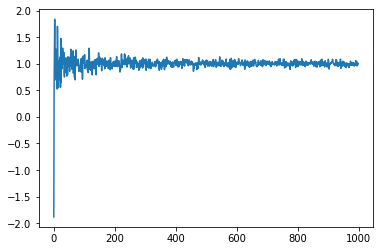

In [ ]:
output = []
r = 0.5
for i in range(1,1000):
  x = 1 + np.random.binomial(i-1,0.5) #the +1 comes from the self-loop, that's fine
  y = np.random.normal(i*r,1) 
  output.append(x/y)
plt.plot(output)
plt.show
#we observe really nice convergence to 1

Now define a GNN where the coefficients are sampled from $\frac{1}{N(n\times r,\sigma)}$ and set $r = 0.8$ (the Erdos-Renyi parameter). Do we see convergence to the mean $W \mu$, as our hypothesis suggests? 


In [ ]:
class GNNNormal():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)
    

  def forward(self,adj,X,r):
    D = torch.distributions.normal.Normal(adj.shape[0]*r*torch.ones_like(adj),1*torch.ones_like(adj)).sample()
    
    D = 1/D
    coeff =  D*adj
    prod = coeff @ X @ self.W

    return prod

In [ ]:
X_dim = 2
out_channels = 3
mu = 1*torch.ones(1,X_dim)
net = GNNNormal(X_dim, out_channels)
target = mu@net.W

output = experiment(X_dim, net, 500, r = 0.8)
diff1 = []

for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output
   


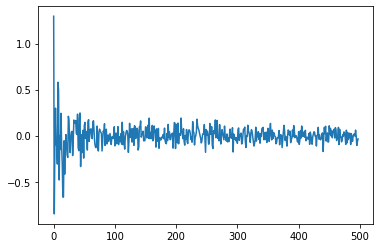

In [ ]:
plt.plot(diff1) #again, nice convergence note that now we are doing it for r = 0.8

Compare this with the GCN plot - this looks like almost sure convergence! 

Now let's try a distribution which is absolutely horrible (according to our hypothesis) for example Uniform(1,n). First let's see how a bad distribution behaves with respect to $Bin(n,r)$:

<function matplotlib.pyplot.show(close=None, block=None)>

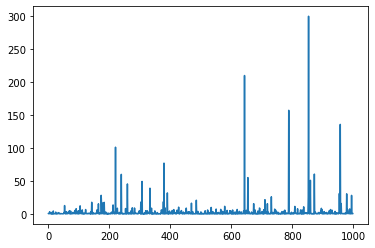

In [ ]:
output = []
l = []
r = 0.5
for i in range(1,1000):
  x = 1+ np.random.binomial(i-1,r)
  y = np.random.uniform(1,i) 
  output.append(x/y)
plt.plot(output)
plt.show

Obviously if these are our attention weights, we cannot expect any sort of convergence. Let's do it anyway so that we see what a bad plot looks like:

In [ ]:
class GNNUniform():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)
    

  def forward(self,adj,X,r):
    D = torch.distributions.uniform.Uniform(torch.ones_like(adj),adj.shape[0]*torch.ones_like(adj)).sample()
    D = 1/D
    coeff =  D*adj
    prod = coeff @ X @ self.W

    return prod

In [ ]:
X_dim = 2
out_channels = 3
mu = 1*torch.ones(1,X_dim)
net = GNNUniform(X_dim, out_channels)
target = mu@net.W

output = experiment(X_dim, net, 500, r = 0.8)
diff1 = []
for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output


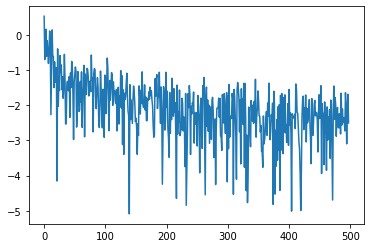

In [ ]:
plt.plot(diff1)

Clearly not convergent - recall that for convergence we need to be around 0, because we are measuring distance from mean. 

Now let's try something more delicate. Let us look for a distribution which satisfies the condition in probability, but NOT almost surely.



<function matplotlib.pyplot.show(close=None, block=None)>

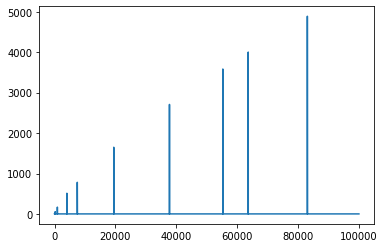

In [ ]:
output = []
l = []
r = 0.5
for i in range(1,100000):
  x = 1+ np.random.binomial(i-1,r)
  y = np.random.binomial(1,1/i) 
  if y == 1:
    y = r*i**(1/4) #this was for 1/4, I forgot to change it
  else:
    y = i*r
  output.append(x/y)
plt.plot(output)
plt.show
#Converges in probability but not almost sure

Now let's implement a GNN whose attention weights have this distribution. Will we observe convergence?

In [ ]:
class GNNWeird():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)
    

  def forward(self,adj,X,r):
    n = adj.shape[0]
    D = torch.distributions.binomial.Binomial(torch.ones_like(adj),(1/n)*torch.ones_like(adj)).sample()
    
    A = n*r*torch.ones_like(D)
    B = r*n**(1/8)*torch.ones_like(D)
  
    D = torch.where(D == 0, D, B)
   
    D = torch.where((D == r*n**(1/8)), D, A)
    D = 1/D
    coeff =  D*adj
    prod = coeff @ X @ self.W

    return prod

In [ ]:
X_dim = 2
out_channels = 3
mu = 1*torch.ones(1,X_dim)
net = GNNWeird(X_dim, out_channels)
target = mu@net.W

output = experiment(X_dim, net, 500, r = 1)
diff1 = []
for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output


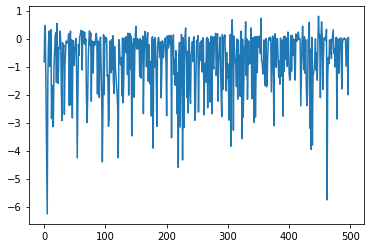

In [ ]:
plt.plot(diff1)

This does not converge almost surely. But is it really happening because of the almost sure vs convergence in probability? Let's take the same distribution, but now change the probability from $1/n$ to $1/n^2$. This gives almost sure convergence: 

<function matplotlib.pyplot.show(close=None, block=None)>

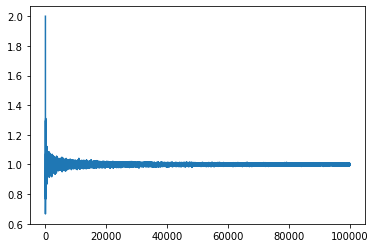

In [ ]:
output = []
l = []
r = 0.5
for i in range(1,100000):
  x = 1+ np.random.binomial(i-1,r)
  y = np.random.binomial(1,1/i**2) 
  if y == 1:
    y = r*i**(1/8)
  else:
    y = i*r
  output.append(x/y)
plt.plot(output)
plt.show
#Now converges almost surely

So how does the GNN behave now?

In [ ]:
class GNNWeird2():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)
    

  def forward(self,adj,X,r):
    n = adj.shape[0]
    D = torch.distributions.binomial.Binomial(torch.ones_like(adj),(1/n**2)*torch.ones_like(adj)).sample() #note the n**2 - the only thing that changes
    
    A = n*r*torch.ones_like(D)
    B = r*n**(1/8)*torch.ones_like(D)
  
    D = torch.where(D == 0, D, B)
   
    D = torch.where((D == r*n**(1/8)), D, A)
    D = 1/D
    coeff =  D*adj
    prod = coeff @ X @ self.W

    return prod

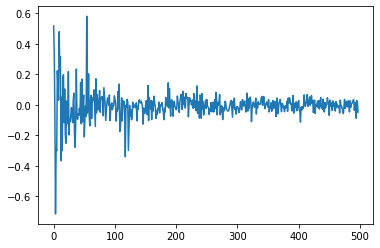

In [ ]:
X_dim = 2
out_channels = 3
mu = 1*torch.ones(1,X_dim)
net = GNNWeird2(X_dim, out_channels)
target = mu@net.W

output = experiment(X_dim, net, 500, r = 1)
diff1 = []
diff2 = []
diff3 = []
for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output
  diff2.append(target[0][1] - output[i][1])
  diff3.append(target[0][2] - output[i][2])  
plt.plot(diff1)

Now we get beautiful convergence. This suggests that the almost sure convergence vs convergence in probability is something not to be overlooked. 

However, this example was quite pathological, because there was an "exploding" subsequence. Can we find a distribution which is firstly continuous and secondly, not as bad? It turns out this is not that easy to find (for the Binomial dist), but one can prove that the Cauchy distribution satisfies what we want - its ratio with the binomial distribution converges in probability, but not almost surely and it is continuous. Once again, you can do so using the Borel Cantelli lemmas. Let's look into the experiments:



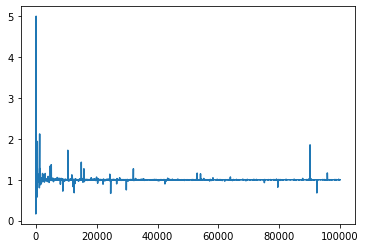

In [ ]:
import scipy.stats
output = []
dist = []
r = 1
for i in range(2,100000):
  y = 1+ np.random.binomial(i-1,r)
  x = abs(scipy.stats.cauchy.rvs(loc=i, scale=1, size=1))
  dist.append(x)
  output.append(y/x)
plt.plot(output)
plt.show()

Now we see the convergence is NOT almost sure, but the "bad" values don't explode (in fact they are very close to 1). Now let's implement a GNN whose attention weights follow this distribution:

In [ ]:
class GNNCauchy():
  def __init__(self,in_dim, out_dim):
    self.W = torch.rand(in_dim,out_dim)
    

  def forward(self,adj,X,r):
    n = adj.shape[0]
    D = torch.distributions.cauchy.Cauchy(n*torch.ones_like(adj), torch.ones_like(adj)).sample()
    D = 1/D
    conv =  D*adj
    sum = conv@X
    prod = sum @ self.W

    return prod

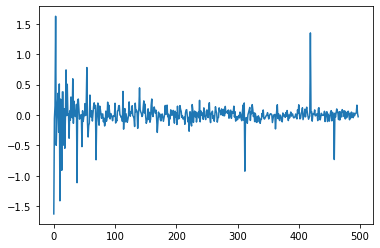

In [ ]:
X_dim = 2
out_channels = 3
mu = 1*torch.ones(1,X_dim)
net = GNNCauchy(X_dim, out_channels)
target = mu@net.W

output = experiment(X_dim, net, 500, r = 1)
diff1 = []

for i in range(len(output)):
  diff1.append(target[0][0] - output[i][0]) #compute distance between mean and output 
plt.plot(diff1)

Notice that now we have outliers - this is exactly the difference between almost sure convergence and convergence in probability. In my opinion, this suggests that the first part of the conjecture is correct, and that indeed the driving mechanism is the strong law of large numbers. 




#Claim 2: Zero One Law

While all of the above is nice, it is quite unlikely that we will be able to spot a difference when it comes to the zero one laws. The reason is that even if the convergence has these oscillations, the mean (the value it is converging to) would need to be very close to the classification boundary in order for these oscillations to impact the resulting label. One way to test this would be to find a classifier for which the the value we are converging to is really close to the classification boundary - but this is not trivial to do. For this reason, I've decided to slightly change the experimental setup. Instead of looking at the graph labels, we will look at whether the embeddings converge to the mean and draw conclusions from that. Note that this is inline with the theory given in the paper. 

Our setup is very similar to the one in the paper: We will have a GNN with 3 layers. Initially, the GNN will not have a nonlinearity (in the paper a truncated identity was used), because I believe that actually, the nonlinearity **amplifies** the convergence behaviour (I don't want to go into this). The GNN obtains the graph label using average pooling.

The key difference is that in our setup, the "attention weights" are sampled from a distribution. We want to understand how this distribution affects the convergence of the embeddings. For this reason, we will compute the normalized $L2$ distance of the pooled embeddings from the target value, which is the value that theory suggests we should converge to. 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
class GNNCauchy():
  def __init__(self,in_dim, hid_dim = 3):
    self.W = torch.rand(in_dim,hid_dim)*(-2)+1
    self.W2 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.W3 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.weights = [self.W, self.W2, self.W3]
    
  def forward(self,adj,X,r):
    n = adj.shape[0]
    for i in range(3):
      D = torch.distributions.cauchy.Cauchy(n*r*torch.ones_like(adj), torch.ones_like(adj)).sample()
      D = 1/D 
      X = (D*adj) @ X @ self.weights[i]
    
    X = torch.mean(X,dim = 0).unsqueeze(dim = 1)
    return X

In [ ]:
class GNNNormal():
  def __init__(self,in_dim,hid_dim = 3):
    self.W = torch.rand(in_dim,hid_dim)*(-2)+1
    self.W2 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.W3 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.weights = [self.W, self.W2, self.W3]

  def forward(self,adj,X,r):
    
    n = adj.shape[0]
    for i in range(3):
      D = torch.distributions.normal.Normal(n*r*torch.ones_like(adj),1*torch.ones_like(adj)).sample()
      D = 1/D  
      X = (D*adj) @ X @ self.weights[i]
    
    X = torch.mean(X,dim = 0).unsqueeze(dim = 1)
    
    return X

In [ ]:
class GNNUniform():
  def __init__(self,in_dim, hid_dim = 3):
    self.W = torch.rand(in_dim,hid_dim)*(-2)+1
    self.W2 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.W3 = torch.rand(hid_dim,hid_dim)*(-2)+1
    self.weights = [self.W, self.W2, self.W3]
  def forward(self,adj,X,r):
    n = adj.shape[0]
    for i in range(3):
      D = torch.distributions.uniform.Uniform(1*torch.ones_like(adj), n*torch.ones_like(adj)).sample()
      D = 1/D 
      X = (D*adj) @ X @ self.weights[i]
      
    X = torch.mean(X,dim = 0).unsqueeze(dim = 1)
    
    return X

In [ ]:
#this is the same as before but we start with graphs of size 20 to have nicer plots (sometimes the first few values are wild)

def experiment(X_dim, net, num_graphs = 500, r = 1):
  output = []
  #samples random graphs of size 1,2 .. num_graphs (one graph for each size) with random features

  for n in range(20,num_graphs):
    #prepare self loops
    self_loops = torch.arange(n).reshape(1,n)
    edge_index0 = torch.cat((self_loops,self_loops), dim = 0 )

    #generate random graph from G(n,r)
    edge_index = torch.cat((generate_erdos_renyi(n,r),edge_index0), dim = 1) 
    adj = torch_geometric.utils.to_dense_adj(edge_index)[0] 

    #generate node features
    X = generate_node_features(n,X_dim)

    Y_n = net.forward(adj,X,r)
  
    output.append(Y_n[0]) #only look at one vertex 
  
  return output

In [ ]:
X_dim = 32
hid_dim = 16
mu = 1*torch.ones(1,X_dim)
nets = [GNNNormal(X_dim,hid_dim), GNNCauchy(X_dim,hid_dim), GNNUniform(X_dim,hid_dim)]
targets = []
for net in nets:  
  targets.append(torch.tensor(mu@net.W@net.W2@net.W3))

distances = []
for i in range(len(nets)):
  distance = []
  output = experiment(X_dim, nets[i], 500, r = 1/2)
  for j in range(len(output)):
    distance.append((1/X_dim)*torch.linalg.vector_norm(targets[i] - output[j]))
  distances.append(distance)


<ipython-input-49-fb3f514d3ec2>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets.append(torch.tensor(mu@net.W@net.W2@net.W3))


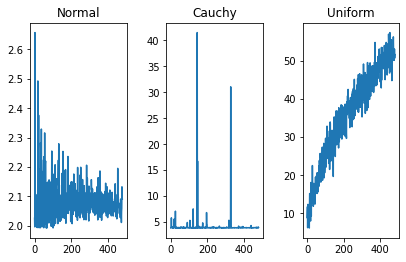

In [ ]:
figure, axis = plt.subplots(1, 3)
  

axis[0].plot(distances[0])
axis[0].set_title("Normal")
  

axis[1].plot(distances[1])
axis[1].set_title("Cauchy")
  

axis[2].plot(distances[2])
axis[2].set_title("Uniform")

figure.tight_layout(pad = 2)
plt.show()

In my opinion, the plots are surprisingly nice. We see almost sure convergence in the first plot, convergence in probability in the second plot (look at the values on the y-axis) and divergence in the third plot. For some reason, the first plot is not exactly around the value 0 - in my opinion, this is because now we are computing the average distance over 32 dimensions and perhaps the convergence is slower - one would need to test this for larger graphs. Nevertheless, we see the behaviour that was predicted. 

So what is the verdict for the zero one laws? If you actually assign labels for the above graphs, you will see that all 3 cases satisfy a zero one law, but for different reasons. The first plot satisfies the zero one law for reasons predicted by the theory. The "Uniform" case satisfies a zero one law because the embeddings diverge to infinity, so the classification boundary will eventually be crossed and the classifier will produce the same label. 
The second plot satisfies a zero one law most of the time, in the sense that the target would need to be close to the classification boundary in order for the labels to oscillate. But even if the classification boundary was close, the second case would satisfy the zero one law **in probability** but NOT almost surely, meaning that you would have an infinite sequence of "bad" labels. As I said before, to verify this experimentally, your target would have to be close to the classification boundary - I leave this task for future study. To conclude this section, we can now modify our conjecture: 


Let $M$ be a GNN with the aggregation scheme
$$
y_v^1 = \sum_{u \in N(v)}\alpha_{vu}W_1x_u 
$$

where $\alpha_{vu} \sim D(n)$ are independent and $N(v)$ follows a distribution according to the random graph model. Then we have the following cases:

1.  If $D(n)$ and the random graph model are such that $D(n) \times |N(v)| \to c$ almost surely, then the zero one law is satisfied almost surely
2. If $D(n)$ and the random graph model are such that $D(n) \times |N(v)| \to c$ in probability, then the zero one law is satisfied in probability
3. If $D(n)$ and the random graph model are such that $D(n) \times |N(v)| \to \infty$ almost surely/in probability then the zero one law is satisfied almost surely/in probability

Note that case 1 includes the case when $c = 0$, meaning that one of the distributions "beats" the other and the embeddings converge to zero. 

In my opinion, it is quite hard to find a distribution that doesn't fall to any of the above cases - you need something which doesn't converge nor diverge in relation to the random graph model. 


So perhaps thinking about the zero one laws in connection to the strong law of large numbers can bring new insights into the problem. 


**Disclaimer**
I am not saying that our experiments prove this conjecture. 

# Final remarks

A small problem of our approach is that the model we are considering is in fact too general. For example, graph attention networks have a strong constraint on the coefficients - they must sum to 1. This means that the above findings don't directly apply. But thanks to the above section we have a very detailed understanding of the convergence behaviour and we know exactly what must be done in order to understand the zero one laws of GATs - one must simply do the above analysis using distributions that sum to one.  For example, if the distribution of the coefficients is such that they are all equal (or similar), we are in case 1 and we will see almost sure convergence. Since I am way over the page limit,  I defer this task to another time. 

I hope you found this at least a little interesting. 